In [83]:
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

def generate_sparse_matrix(rows, cols, sparsity):
	"""
	生成一个随机稀疏矩阵，并以CSR格式存储。
	
	参数:
	rows (int): 矩阵的行数
	cols (int): 矩阵的列数
	sparsity (float): 稀疏度（0到1之间的浮点数，表示矩阵中零元素的比例）
	
	返回:
	csr_matrix: 以CSR格式存储的稀疏矩阵
	"""
	matrix = np.random.rand(rows, cols)
	
	mask = np.random.rand(rows, cols) > sparsity
	matrix[mask] = 0
	
	sparse_matrix = csr_matrix(matrix)
	
	return sparse_matrix

def plot_sparse_matrix(sparse_matrix, verbose=True):
	plt.figure(figsize=(8, 8))
	
	# 转换为稀疏矩阵的二维数组表示
	matrix_dense = sparse_matrix.toarray()
	# zero_mask = (matrix_dense == 0)
	
	plt.imshow(matrix_dense, cmap="Blues", alpha=1)
	
	# 在非零元素处标记其值，保留一位小数
	for i in range(matrix_dense.shape[0]):
		for j in range(matrix_dense.shape[1]):
			if matrix_dense[i, j] != 0:
				if (verbose):
					plt.text(j, i, f'{matrix_dense[i, j]:.1f}', ha='center', va='center', color='black')
	
	plt.colorbar(label="Value")
	plt.title("Sparse Matrix Visualization with Values")
	plt.show()



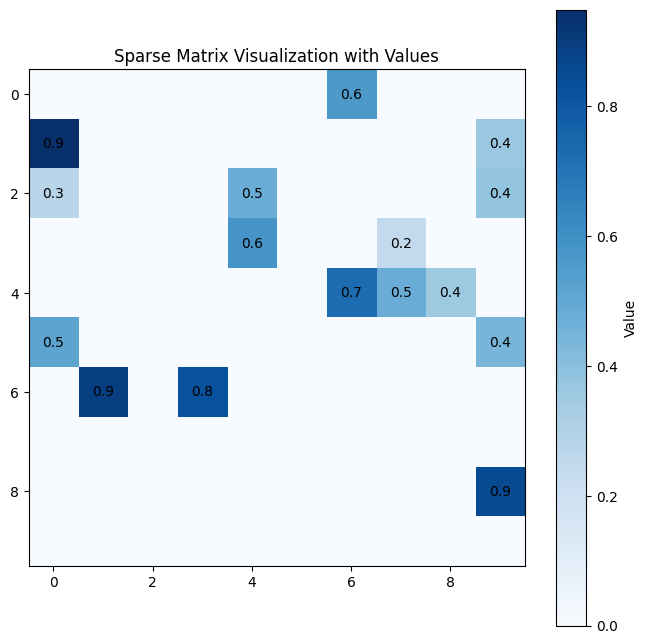

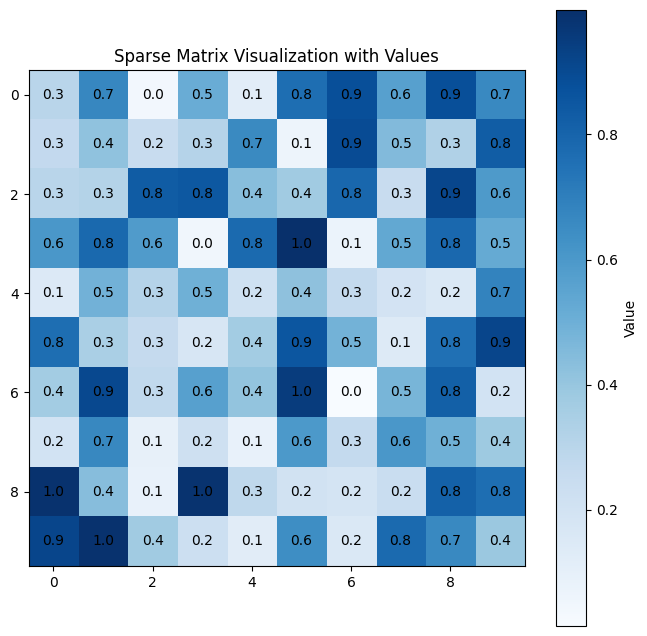

In [64]:
matrixA_sparsity = generate_sparse_matrix(rows=10, cols=10, sparsity=1/5)
matrixB_density  = generate_sparse_matrix(rows=10, cols=10, sparsity=1)
plot_sparse_matrix(matrixA_sparsity)
plot_sparse_matrix(matrixB_density)

In [24]:
matrixA_sparsity.data

array([ 0,  2,  4,  5,  6, 11, 12, 13, 16, 18, 20], dtype=int32)

In [25]:
matrixA_sparsity.indices

array([8, 9, 2, 4, 5, 8, 1, 6, 7, 8, 9, 1, 1, 0, 4, 7, 3, 9, 3, 6],
      dtype=int32)

In [26]:
matrixA_sparsity.indptr


array([ 0,  2,  4,  5,  6, 11, 12, 13, 16, 18, 20], dtype=int32)

In [77]:
def move_row_up_limited(matrix_sparsity):
		"""
		查找稀疏矩阵中每行的非零元素，将整行向上移动，
		直到上面一行的对应位置有值为止。
		
		参数:
		matrix_sparsity (csr_matrix): 输入的稀疏矩阵，CSR格式
		
		返回:
		csr_matrix: 处理后的稀疏矩阵
		"""
		# 将稀疏矩阵转换为密集矩阵以便操作
		dense_matrix = matrix_sparsity.toarray()
		rows, cols = dense_matrix.shape

		# 从第二行开始处理，第一行没有上方行可比较
		for i in range(1, rows):
				while True:
						current_row = dense_matrix[i, :]
						above_row = dense_matrix[i - 1, :]

						# 查找当前行的非零元素
						non_zero_indices = np.nonzero(current_row)[0]

						# 检查是否所有非零元素的上方位置为空
						can_move_up = all(above_row[idx] == 0 for idx in non_zero_indices)

						if can_move_up:
								# 将整行的非零元素移动到上方行
								dense_matrix[i - 1, non_zero_indices] = current_row[non_zero_indices]
								# 清空当前行的这些位置
								dense_matrix[i, non_zero_indices] = 0
								# 更新索引，继续检查更上方的行
								if i > 1:
										i -= 1
								else:
										break
						else:
								break

		# 转换回CSR格式
		return csr_matrix(dense_matrix)

def move_row_up_no_dependency(matrix_sparsity):
		"""
		查找稀疏矩阵中每行的非零元素，并将这些元素向上移动，
		直到上面对应的位置有非零元素为止。
		
		参数:
		matrix_sparsity (csr_matrix): 输入的稀疏矩阵，CSR格式
		
		返回:
		csr_matrix: 处理后的稀疏矩阵
		"""
		# 将稀疏矩阵转换为密集矩阵以便操作
		dense_matrix = matrix_sparsity.toarray()
		rows, cols = dense_matrix.shape

		# 遍历每一行，从第二行开始处理
		for i in range(1, rows):
				for j in range(cols):
						if dense_matrix[i, j] != 0:  # 当前行非零元素
								k = i
								# 向上移动直到找到非零元素或到达第一行
								while k > 0 and dense_matrix[k - 1, j] == 0:
										dense_matrix[k - 1, j] = dense_matrix[k, j]
										dense_matrix[k, j] = 0
										k -= 1

		# 转换回CSR格式
		return csr_matrix(dense_matrix)

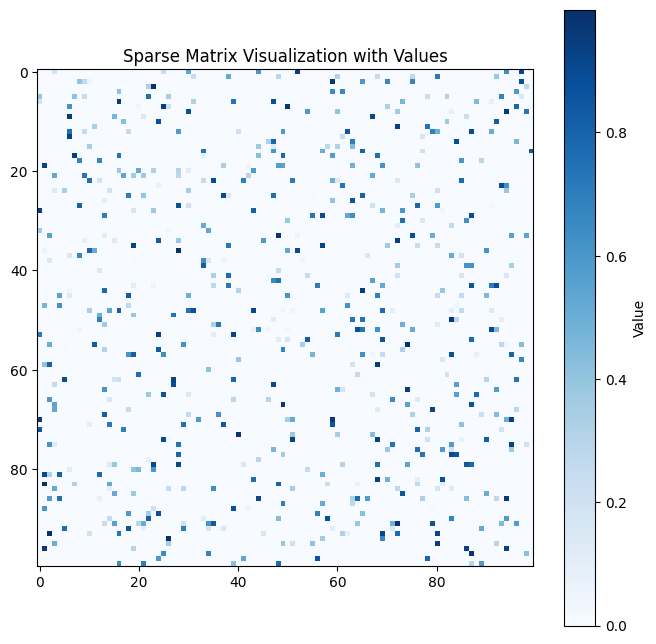

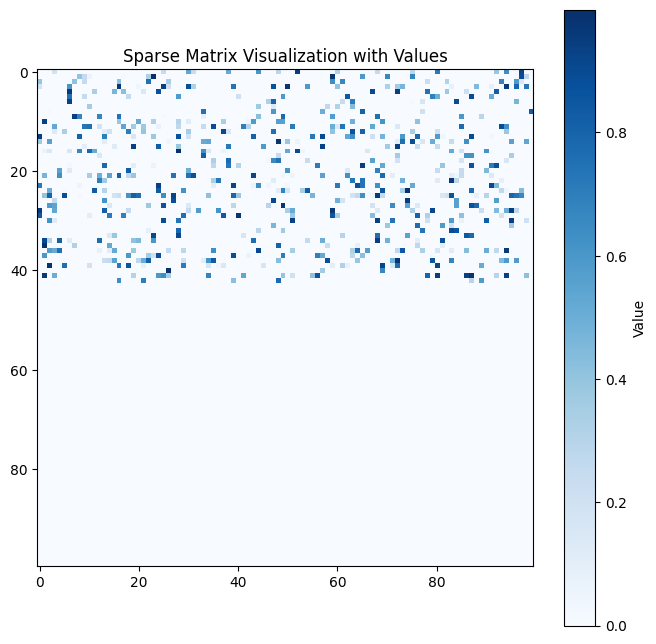

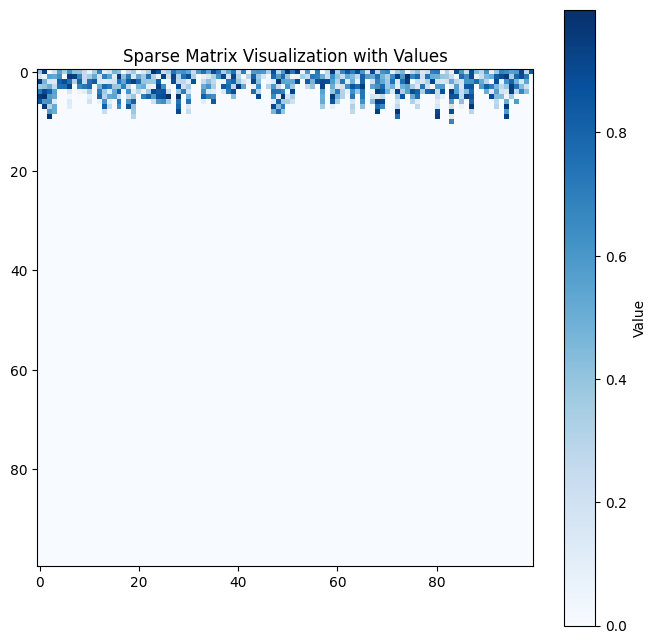

(100, 100)
(100, 100)


In [87]:
matrixA_sparsity = generate_sparse_matrix(rows=100, cols=100, sparsity=1/16)
matrixA_sparsity_up_limited  = move_row_up_limited(matrixA_sparsity)
matrixA_sparsity_up_no_limited  = move_row_up_no_dependency(matrixA_sparsity)
plot_sparse_matrix(matrixA_sparsity, verbose=False)
plot_sparse_matrix(matrixA_sparsity_up_limited, verbose=False)
plot_sparse_matrix(matrixA_sparsity_up_no_limited, verbose=False)

print(matrixA_sparsity_up_limited.shape)
print(matrixA_sparsity_up_no_limited.shape)

In [46]:
def get_column_vector(matrixB, col_index):
		"""
		根据稀疏矩阵A的列索引获取对应密集矩阵B的列向量。
		
		参数:
		matrixB (np.ndarray): 密集矩阵B
		col_index (int): 稀疏矩阵A中的列索引
		
		返回:
		np.ndarray: 密集矩阵B中的列向量
		"""
		return matrixB[:, col_index]

def spmm(matrixA_sparsity, matrixB_density):
		"""
		计算稀疏矩阵A与密集矩阵B的乘法运算，跳过稀疏的部分。
		
		参数:
		matrixA_sparsity (csr_matrix): 稀疏矩阵A，CSR格式
		matrixB_density (np.ndarray): 密集矩阵B，普通二维数组格式
		
		返回:
		np.ndarray: 结果矩阵C
		"""
		# 获取稀疏矩阵的维度
		A_rows, cols = matrixA_sparsity.shape

		# 初始化结果矩阵C
		result = np.zeros((A_rows, matrixB_density.shape[1]))
		
		# 计算稀疏矩阵A与密集矩阵B的乘积
		for i in range(A_rows):
				# 获取稀疏矩阵A的第i行
				start_idx = matrixA_sparsity.indptr[i]
				end_idx = matrixA_sparsity.indptr[i + 1]
				A_row_indices = matrixA_sparsity.indices[start_idx:end_idx]
				A_row_values = matrixA_sparsity.data[start_idx:end_idx]
				# 对于A中每个非零元素
				for j, col_idx in enumerate(A_row_indices):
						# 获取对应的密集矩阵B的列向量
						B_col_vector = get_column_vector(matrixB_density, col_idx)
						# 累加到结果矩阵的第i行
						result[i, :] += A_row_values[j] * B_col_vector.T
		
		return result


In [47]:
# 计算稀疏矩阵乘法
result_matrix = spmm(matrixA_sparsity, matrixB_density)

# 打印结果
print("Result of SPMM (Sparse Matrix * Dense Matrix):")
print(result_matrix)

Result of SPMM (Sparse Matrix * Dense Matrix):
[[0.14762    0.03701319 0.04019238 0.05038439 0.01513539]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.52654252 0.25018336 0.30176587 0.06081483 0.7073598 ]
 [0.         0.         0.         0.         0.        ]]


In [57]:
def systolic_array_spmm(matrixA_sparsity, matrixB_density):
		"""
		使用脉动阵列计算稀疏矩阵A与密集矩阵B的乘法，并返回计算延迟。
		
		参数:
		matrixA_sparsity (csr_matrix): 稀疏矩阵A，CSR格式
		matrixB_density (np.ndarray): 密集矩阵B，普通二维数组格式
		
		返回:
		tuple: (result_matrix, latency)
				- result_matrix: 计算结果矩阵
				- latency: 计算延迟（以时钟周期为单位）
		"""
		# 获取稀疏矩阵的维度
		rows, cols = matrixA_sparsity.shape
		num_pes = cols  # 脉动阵列中的处理元素(PEs)的数量，通常与矩阵的列数相同

		# 初始化结果矩阵C
		result = np.zeros((rows, matrixB_density.shape[1]))

		# 初始化延迟计数器
		latency = num_pes  # 初始延迟等于第一行需要完成的时间

		# 脉动阵列计算
		for i in range(rows):
				# 获取稀疏矩阵A的第i行
				start_idx = matrixA_sparsity.indptr[i]
				end_idx = matrixA_sparsity.indptr[i + 1]
				A_row_indices = matrixA_sparsity.indices[start_idx:end_idx]
				A_row_values = matrixA_sparsity.data[start_idx:end_idx]

				# 对于A中每个非零元素
				for j, col_idx in enumerate(A_row_indices):
						# 获取对应的密集矩阵B的列向量
						column_vector_B = matrixB_density[:, col_idx]
						# 将列向量转置为行向量并累加到结果矩阵的第i行
						result[i, :] += A_row_values[j] * column_vector_B.T
						
		# 如果有多于一行，之后的每行计算增加1个时钟周期（并行计算导致的延迟重叠）
				if i > 0:
						latency += 1

		return result, latency


In [58]:
# 计算稀疏矩阵乘法
result_matrix, latency = systolic_array_spmm(matrixA_sparsity, matrixB_density)
latency

19